In [ ]:
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
import matplotlib.pyplot as plt
import numpy as np
import copy as cp
import math
import random

In [ ]:
def get_reward(p, action):
  if np.random.random() < p[action]:
    return 1
  else:
    return 0

def greedy(values):
  max_values = np.where(values ==values.max())[0]
  return np.random.choice(max_values)

def ranodm_propability(k):
  return np.random.rand(k)

def shuffle_all_move(items):
    rand_ord = random.sample(range(len(items)), k=len(items))
    return [items[r] for i, r in sorted(zip(rand_ord, rand_ord[1:]+rand_ord[:1]))]

In [ ]:
class Agent():
  def __init__(self, k):
    self.k = k
    self.arm_counts = np.zeros(k)
    self.arm_rewards = np.zeros(k)
    self.E = np.array([0.5]*k)

  def recet_params(self):
    self.arm_counts = np.zeros(k)
    self.arm_rewards = np.zeros(k)
    self.E = np.array([0.5]*k)

  def select_arm(self):
    pass

  def update(self, selected, reward):
    pass

In [ ]:
class RS(Agent):
    def __init__(self, k, opt, aleph):
        super().__init__(k)
        self.count = 0
        self.reward_sum = 0
        self.aleph = 1
        self.alpha = 0.0005

    def reset_params(self):
        super().recet_params()

    def select_arm(self):
        RS = (self.arm_counts/ self.count)*(self.E - self.aleph)
        return np.argmax(RS)

    def update(self, action, reward):
        self.count += 1
        self.arm_counts[action] += 1
        self.arm_rewards[action] += reward
        self.reward_sum += reward

        a = 1/(self.arm_counts[action] + 1)
        self.E[action] = (1- a) * self.E[action] + a * reward
        self.aleph += self.alpha * (self.E[action] - self.aleph)

################################################
class RS_OPT(Agent):
    def __init__(self, k, opt, aleph):
        super().__init__(k)
        self.count = 0
        self.reward_sum = 0
        self.opt = opt

    def reset_params(self):
        super().recet_params()

    def select_arm(self):
        RS = (self.arm_counts/ self.count)*(self.E - self.opt)
        return np.argmax(RS)

    def update(self, action, reward):
        self.count += 1
        self.arm_counts[action] += 1
        self.arm_rewards[action] += reward
        self.reward_sum += reward

        alpha = 1/(self.arm_counts[action] + 1)
        self.E[action] = (1- alpha) * self.E[action] + alpha * reward

################################################
class TS(Agent):
    def __init__(self, k, opt, aleph):
        super().__init__(k)
        self.count = 0
        self.reward_sum = 0
        self.success = np.zeros(k)
        self.fail = np.zeros(k)
        self.mu = np.zeros(k)

    def reset_params(self):
        super().recet_params()

    def select_arm(self):
        return np.argmax(self.mu)

    def update(self, action, reward):
        self.count += 1
        self.arm_counts[action] += 1
        self.arm_rewards[action] += reward
        self.reward_sum += reward

        if reward == 1:
          self.success[action] += 1
        else:
          self.fail[action] += 1
        self.E[action] = ((self.arm_counts[action]-1)/self.arm_counts[action])*self.E[action] + (1/self.arm_counts[action]) * reward
        self.mu = np.array([np.random.beta(self.success[action]+1, self.fail[action]+1) for action in range(self.k)])

################################################
class UCB1T(Agent):
    def __init__(self, k, opt, aleph):
        super().__init__(k)
        self.count = 0
        self.reward_sum = 0
        self.var = np.zeros(k)
        self.ucb = np.zeros(k)
        self.c = 1.0

    def reset_params(self):
        super().recet_params()

    def select_arm(self):
        return np.argmax(self.ucb)

    def update(self, action, reward):
        self.count += 1
        self.arm_counts[action] += 1
        self.arm_rewards[action] += reward
        self.reward_sum += reward
        # self.E[action] = self.E[action] + (reward - self.E[action])/self.arm_counts[action]
        self.E[action] = (1/(self.arm_counts[action]+1))*(self.arm_counts[action]*self.E[action] + reward)

        self.var[action] += ((reward - self.E[action])**2) / self.arm_counts[action]
        v = self.var + np.sqrt(2*np.log(self.count)/self.arm_counts)
        min = []
        for i in range(self.k):
          if v[i]>1/4:
            min.append(1/4)
          else:
            min.append(v[i])       
        self.ucb = self.E + self.c*np.sqrt((np.log(self.count)/self.arm_counts)*min)

################################################
class Greedy(Agent):
    def __init__(self, k, opt, aleph):
      super().__init__(k)
      self.count = 0
      self.reward_sum = 0
      self.opt = opt

    def reset_params(self):
      super().recet_params()

    def select_arm(self):
      max_values = np.where(self.E ==self.E.max())[0]
      return np.random.choice(max_values)

    def update(self, action, reward):
      self.count += 1
      self.arm_counts[action] += 1
      self.arm_rewards[action] += reward
      self.reward_sum += reward

      self.E[action] = self.E[action] + (reward - self.E[action])/self.arm_counts[action]

################################################
class SRS(Agent):
    def __init__(self, k, opt, aleph):
      super().__init__(k)
      self.count = 0
      self.reward_sum = 0
      self.epsilon = 10**-4
      self.aleph = aleph
      self.pi = np.array([1/k]*k)

    def reset_params(self):
      super().recet_params()

    def select_arm(self):
      return np.random.choice(len(self.pi), p=self.pi)

    def update(self, action, reward):
      self.count += 1
      self.arm_counts[action] += 1
      self.arm_rewards[action] += reward
      self.reward_sum += reward
      self.E[action] = self.E[action] + (reward - self.E[action])/self.arm_counts[action]

      E_max = self.E.max()
      tmp_E = self.E
      if E_max > self.aleph:
        tmp_E = tmp_E - E_max + self.aleph - self.epsilon
      
      Z = 1/(np.sum(1/(self.aleph - tmp_E)))
      row = Z/(self.aleph - tmp_E)
      b = (self.arm_counts / row) - self.count + self.epsilon

      SRS = (self.count + b.max()) * row - self.arm_counts
      self.pi = SRS/np.sum(SRS)

################################################
class SRS_OPT(Agent):
    def __init__(self, k, opt, aleph):
      super().__init__(k)
      self.count = 0
      self.reward_sum = 0
      self.epsilon = 10**-4
      self.opt = opt
      self.pi = np.array([1/k]*k)

    def reset_params(self):
      super().recet_params()

    def select_arm(self):
      return np.random.choice(len(self.pi), p=self.pi)

    def update(self, action, reward):
      self.count += 1
      self.arm_counts[action] += 1
      self.arm_rewards[action] += reward
      self.reward_sum += reward
      self.E[action] = self.E[action] + (reward - self.E[action])/self.arm_counts[action]

      E_max = self.E.max()
      tmp_E = self.E
      if E_max > self.opt:
        tmp_E = tmp_E - E_max + self.opt - self.epsilon
      
      Z = 1/(np.sum(1/(self.opt - tmp_E)))
      row = Z/(self.opt - tmp_E)
      b = (self.arm_counts / row) - self.count + self.epsilon

      SRS = (self.count + b.max()) * row - self.arm_counts
      self.pi = SRS/np.sum(SRS)

In [ ]:
class metabandit(Agent):
  def __init__(self, p, k, agent, higher_agent, L, delta=0, lmd=30): # ２つの方策が必要
    super().__init__(k)
    self.k = k
    self.alert = 0
    self.step = 0
    # RS
    p = sorted(p, reverse=True)
    self.aleph = p[0]
    self.opt = (p[0] + p[1]) / 2
    # agent
    self.copy_agent = agent(k, self.opt, self.aleph)
    self.old_agent = agent(k, self.opt, self.aleph)
    self.new_agent = agent(k, self.opt, self.aleph)
    # agent_copy
    self.copy_higher_agent = higher_agent(2, self.opt, self.aleph)
    self.higher_agent = higher_agent(2, self.opt, self.aleph)
    # new or old
    self.select_agent = 0
    # param
    self.delta = 0
    # detection
    self.lmd = lmd
    self.L = L
    self.l_count = 0
    self.mt_sum = 0
    self.MT = 0

  def reset_params(self):
    self.alert = 0
    self.l_count = 0
    self.mt_sum = 0
    self.MT = 0

  def select_arm(self):

    if self.alert:
      # 1--> new,    0--> old
      self.select_agent = self.higher_agent.select_arm()
      if self.select_agent ==0:
        return  self.old_agent.select_arm()
      else:
        return  self.new_agent.select_arm()
    else:
      return  self.old_agent.select_arm()

  def meta_updata(self, action, reward):
    self.step += 1

    if self.alert==1:
      self.l_count+=1
      self.higher_agent.update(self.select_agent, reward)
      self.old_agent.update(action, reward)
      self.new_agent.update(action, reward)

      if self.l_count == self.L:
        self.reset_params()

        if greedy(self.higher_agent.arm_rewards) == 1:
          self.old_agent = self.new_agent

    else: # False
      self.old_agent.update(action, reward)
      average = self.old_agent.reward_sum / self.old_agent.count
      mt = reward - average + self.delta
      self.mt_sum += mt

      if self.mt_sum > self.MT:
        self.MT = self.mt_sum
      PHt = self.MT - self.mt_sum

      # 超えたらアラーム: True
      if PHt > self.lmd:
        self.alert = 1
        self.new_agent = cp.deepcopy(self.copy_agent)
        self.higher_agent = cp.deepcopy(self.copy_higher_agent)

In [ ]:
class Simulator:
  def __init__(self, n_sim, steps, k, unsteady):
    self.Step = steps
    self.Sim = n_sim
    self.k = k
    self.unsteady = unsteady

  def simulation(self, agent, higher_agent, L):
    regret = np.zeros((self.Sim, self.Step))
    for sim in tqdm(range(self.Sim)):
      p = ranodm_propability(k)
      meta = metabandit(p=p, k=k, agent=agent, higher_agent=higher_agent, L=L)
      for step in range(1,self.Step):
        if self.unsteady == 1:
          if step%2000==0:
            p = shuffle_all_move(p)
        action = meta.select_arm()
        reward = get_reward(p, action)
        meta.meta_updata(action, reward)
        regret[sim, step] += regret[sim, step-1] + np.max(p) - p[action]

    return regret

In [ ]:
n_sim = 100
steps = 100000
k = 20

simulata = Simulator(n_sim=n_sim, steps=steps, k=k, unsteady=1)
regret_TS = simulata.simulation(TS, TS, L=30)
regret_RS = simulata.simulation(RS, RS, L=30)
regret_RS_OPT = simulata.simulation(RS_OPT, RS_OPT, L=30)
regret_SRS = simulata.simulation(SRS, SRS, L=30)
regret_SRS_OPT = simulata.simulation(SRS_OPT, SRS_OPT, L=30)

# regret_UCB1T = simulata.simulation(UCB1T, UCB1T, L=500)

100%|██████████| 100/100 [25:42<00:00, 15.43s/it]


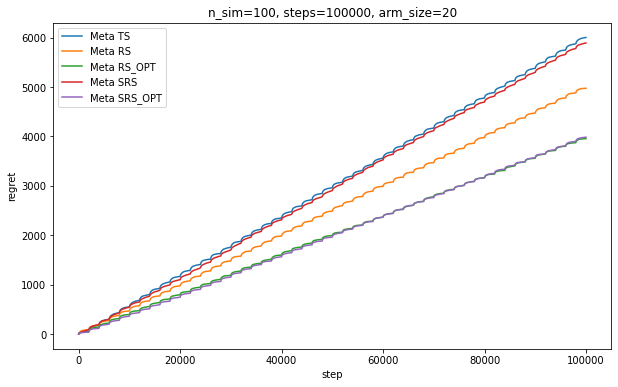

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
# plt.plot(np.mean(regret_UCB1T, axis=0), label="Meta UCB1T")
plt.plot(np.mean(regret_TS, axis=0), label="Meta TS")
plt.plot(np.mean(regret_RS, axis=0), label="Meta RS")
plt.plot(np.mean(regret_RS_OPT, axis=0), label="Meta RS_OPT")
plt.plot(np.mean(regret_SRS, axis=0), label="Meta SRS")
plt.plot(np.mean(regret_SRS_OPT, axis=0), label="Meta SRS_OPT")
plt.title("n_sim={}, steps={}, arm_size={}".format(n_sim, steps, k))
plt.legend()
plt.savefig("result-Meta.jpg")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
regret_RS_gamma = np.load("/content/drive/MyDrive/regret_RS.npy")
regret_RS_OPT_gamma = np.load("/content/drive/MyDrive/regret_RS_OPT.npy")
regret_SRS_gamma = np.load("/content/drive/MyDrive/regret_SRS.npy")
regret_SRS_OPT_gamma = np.load("/content/drive/MyDrive/regret_SRS_OPT.npy")
regret_TS_gamma = np.load("/content/drive/MyDrive/regret_TS.npy")

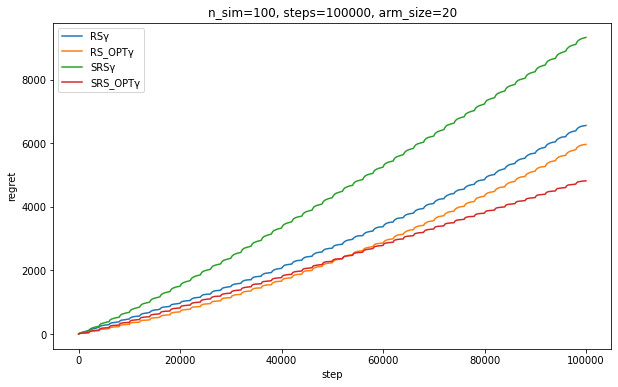

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
# plt.plot(np.mean(regret_UCB1T, axis=0), label="Meta UCB1T")
# plt.plot(np.mean(regret_TS_gamma, axis=0), label="TSγ")
plt.plot(np.mean(regret_RS_gamma, axis=0), label="RSγ")
plt.plot(np.mean(regret_RS_OPT_gamma, axis=0), label="RS_OPTγ")
plt.plot(np.mean(regret_SRS_gamma, axis=0), label="SRSγ")
plt.plot(np.mean(regret_SRS_OPT_gamma, axis=0), label="SRS_OPTγ")
plt.title("n_sim={}, steps={}, arm_size={}".format(n_sim, steps, k))
plt.legend()
plt.savefig("result-Meta.jpg")
plt.show()

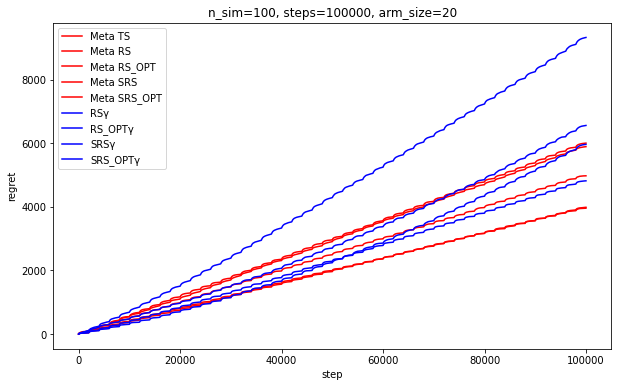

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
# meta
plt.plot(np.mean(regret_TS, axis=0), label="Meta TS", color="r")
plt.plot(np.mean(regret_RS, axis=0), label="Meta RS", color="r")
plt.plot(np.mean(regret_RS_OPT, axis=0), label="Meta RS_OPT", color="r")
plt.plot(np.mean(regret_SRS, axis=0), label="Meta SRS", color="r")
plt.plot(np.mean(regret_SRS_OPT, axis=0), label="Meta SRS_OPT", color="r")
#  gamma
plt.plot(np.mean(regret_RS_gamma, axis=0), label="RSγ", color="b")
plt.plot(np.mean(regret_RS_OPT_gamma, axis=0), label="RS_OPTγ", color="b")
plt.plot(np.mean(regret_SRS_gamma, axis=0), label="SRSγ", color="b")
plt.plot(np.mean(regret_SRS_OPT_gamma, axis=0), label="SRS_OPTγ", color="b")

plt.title("n_sim={}, steps={}, arm_size={}".format(n_sim, steps, k))
plt.legend()
plt.savefig("result-Meta-gamma-br.jpg")
plt.show()

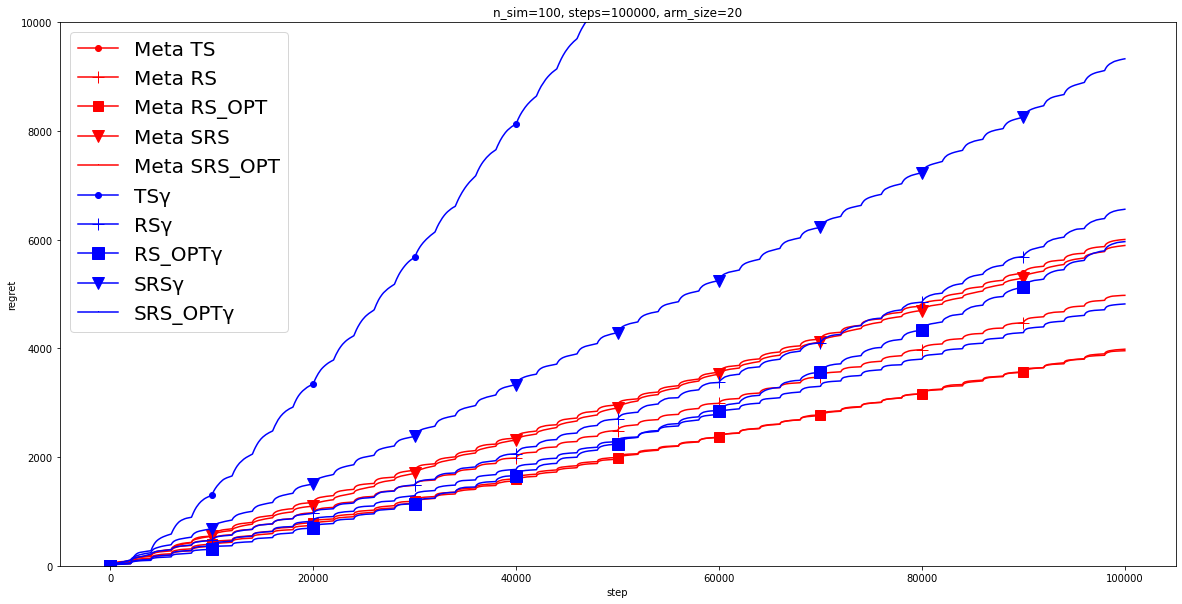

In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel("step")
plt.ylabel("regret")
# meta
plt.plot(np.mean(regret_TS, axis=0), label="Meta TS", color="r", marker=".", markevery=10000, markersize=12)
plt.plot(np.mean(regret_RS, axis=0), label="Meta RS", color="r", marker="+", markevery=10000, markersize=12)
plt.plot(np.mean(regret_RS_OPT, axis=0), label="Meta RS_OPT", color="r", marker="s", markevery=10000, markersize=10)
plt.plot(np.mean(regret_SRS, axis=0), label="Meta SRS", color="r", marker="v", markevery=10000, markersize=12)
plt.plot(np.mean(regret_SRS_OPT, axis=0), label="Meta SRS_OPT", color="r", marker=",", markevery=10000, markersize=12)
# gamma
plt.plot(np.mean(regret_TS_gamma, axis=0)[:70000], label="TSγ", color="b", marker=".", markevery=10000, markersize=12)
plt.plot(np.mean(regret_RS_gamma, axis=0), label="RSγ", color="b", marker="+", markevery=10000, markersize=12)
plt.plot(np.mean(regret_RS_OPT_gamma, axis=0), label="RS_OPTγ", color="b",marker="s", markevery=10000, markersize=12)
plt.plot(np.mean(regret_SRS_gamma, axis=0), label="SRSγ", color="b", marker="v", markevery=10000, markersize=12)
plt.plot(np.mean(regret_SRS_OPT_gamma, axis=0), label="SRS_OPTγ", color="b", marker=",", markevery=10000, markersize=12)

plt.title("n_sim={}, steps={}, arm_size={}".format(n_sim, steps, k))
plt.legend(fontsize=20)
plt.ylim(0,10000)
plt.savefig("result_marker.jpg")
plt.show()